# <font color='BLUE'>DAB303 - FINAL PROJECT - GROUP NUMBER: 33</font>   
- Meghaben - W0749147  
- Vipin - W0755900  
- Yasmin - W0754285  
- Urmi - W0756341  
- Trang Bui - W0753523 

### <font color='Purple'>Dataset   </font>
The dataset and its detail description can be found under the following URL: https://www.kaggle.com/johndddddd/customer-satisfaction?select=satisfaction.xlsx

Raw dataset contains 129880 rows and 24 attributes:

1. Satisfaction: Airline satisfaction level that includes (Satisfaction, neutral or dissatisfaction)  
2. Age:The actual age of the passengers
3. Gender:Gender of the passengers (Female, Male)
4. Type of Travel:Purpose of the flight of the passengers (Personal Travel, Business Travel)
5. Class:Travel class in the plane of the passengers (Business, Eco, Eco Plus)
6. Customer Type:The customer type (Loyal customer, disloyal customer)
7. Flight distance:The flight distance of this journey
8. Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)"
9. Ease of Online booking:Satisfaction level of online booking
10. Inflight service: Satisfaction level of inflight service
11. Online boarding:Satisfaction level of online boarding
12. Inflight entertainment:Satisfaction level of inflight entertainment
13. Food and drink:Satisfaction level of Food and drink
14. Seat comfort:Satisfaction level of Seat comfort
15. On-board service: Satisfaction level of On-board service
16. Leg room service: Satisfaction level of Leg room service
17. Departure/Arrival time convenient:Satisfaction level of Departure/Arrival time convenient
18. Baggage handling:Satisfaction level of baggage handling
19. Gate location:Satisfaction level of Gate location
20. Cleanliness:Satisfaction level of Cleanliness
21. Check-in service: Satisfaction level of Check-in service
22. Departure Delay in Minutes:Minutes delayed when departure
23. Arrival Delay in Minutes:Minutes delayed when Arrival
24. ID: index

### <font color='Purple'>Import Libraries   </font>

In [1]:
# Import the libraries
import warnings
warnings.filterwarnings('ignore')
import time
import os, sys    
from datetime import datetime, date

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv;
import itertools

from pandas.api.types import is_string_dtype, is_object_dtype
from pandas.api.types import is_categorical_dtype, is_string_dtype, is_numeric_dtype
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.subplots as sp #visualization
import plotly.figure_factory as ff#visualization

%matplotlib inline
sns.set()

### <font color='purple'>Data Import</font> 

In [2]:
print('++++++++++ LOAD DATA +++++++++')
def fn_load_data():
    data_raw = pd.read_excel ('satisfaction.xlsx', encoding= 'ISO-8859-1')
    data=data_raw.copy()
    return data, data_raw

data, data_raw = fn_load_data()

data_raw = data_raw.rename(mapper={'satisfaction_v2': 'satisfaction'},axis='columns') 
data = data.rename(mapper={'satisfaction_v2': 'satisfaction'},axis='columns') 

print("Raw Data.shape:",data.shape)
print("Raw Data.info:")
print(data.info())

++++++++++ LOAD DATA +++++++++
Raw Data.shape: (129880, 24)
Raw Data.info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   id                                 129880 non-null  int64  
 1   satisfaction                       129880 non-null  object 
 2   Gender                             129880 non-null  object 
 3   Customer Type                      129880 non-null  object 
 4   Age                                129880 non-null  int64  
 5   Type of Travel                     129880 non-null  object 
 6   Class                              129880 non-null  object 
 7   Flight Distance                    129880 non-null  int64  
 8   Seat comfort                       129880 non-null  int64  
 9   Departure/Arrival time convenient  129880 non-null  int64  
 10  Food and drink               

### <font color='purple'>Data Cleaning</font> 

In [3]:
def df_normalize_values(df):
    print("0. Convert to lower case and convert non-meaningful data to NaN for string and object datatypes")
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)
            df[col] = df[col].replace('??', np.nan)
    return df

def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 100):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['nb of unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] =  df.T.apply(lambda x: x.unique(), axis=1)
        return info.sort_values('data type')
    
def fn_dropmissingrows(df):
    print("1.Drop rows contain all missing values")
    df.dropna(how = 'all')  
    print("+++ Data.shape after dropping missing rows:",df.shape)  
    return df

def fn_dropmissingcols(df_info, df, missingcol, pct_missing):    
    print("2.Drop columns contain >= ", pct_missing,"% missing values")
    idx=0
    for i in list(df_info[df_info[missingcol]>pct_missing].index.values):
        df=df[df.columns.drop(i)]
        idx = idx + 1
    print('+++ The number of dropped columns: ',idx)
    print("+++ Data.shape after dropping missing cols:",df.shape)  
    return df

def fn_dropduplicatedrows(df):
    print("3.Drop duplicated data")
    duplicate_data = df[df.duplicated()] # default is keep the first row
    print('+++ The number of duplicated rows :', len(duplicate_data))
    df.drop_duplicates()
    print("+++ Data.shape after dropping duplicated rows:",df.shape)  
    return df

def fn_dropuniquecols(df, df_info, datalen, colname):
    print("4.Drop unique columns because they are not able to help for model generalization")
    print('+++ List of unique columns will be dropped:')
    for col in list(df_info.index.values):
        if (df_info[colname][col]==datalen):
            print(col)
            df=df.drop(col,axis=1)
    print("+++ Data.shape after dropping unique cols:",df.shape) 
    return df

def fn_handle_missing_numeric_data(df):
    print("6.Handling missing numeric data")
    for col in data.columns:
        if (is_numeric_dtype(df[col])):
            df[col].fillna(df[col].median(), inplace=True)
    print("+++ Data.shape after handling missing numeric data:",df.shape)
    return df


In [4]:
data=data_raw.copy()
print("RAW Data.shape:",data.shape)
data = df_normalize_values(data)
data_info=sniff_modified(data)

data = fn_dropmissingrows(data)

nb_missing_cols=0
nb_missing_cols = len(data_info[data_info['percent missing']>0])
print("Number of missing cols nb_missing_cols = ", nb_missing_cols)

pct_missing = 50
missingcol="percent missing"
if (nb_missing_cols ==0):
    print('There is no missing cols in the dataset')
else:
    data = fn_dropmissingcols(data_info,data,missingcol,pct_missing)

data = fn_dropduplicatedrows(data)

datalen=len(data_raw)
colname='nb of unique'
data = fn_dropuniquecols(data,data_info, datalen, colname)

# replace missing numeric data by replacing with median value
data=fn_handle_missing_numeric_data(data)

data.head()

RAW Data.shape: (129880, 24)
0. Convert to lower case and convert non-meaningful data to NaN for string and object datatypes
1.Drop rows contain all missing values
+++ Data.shape after dropping missing rows: (129880, 24)
Number of missing cols nb_missing_cols =  1
2.Drop columns contain >=  50 % missing values
+++ The number of dropped columns:  0
+++ Data.shape after dropping missing cols: (129880, 24)
3.Drop duplicated data
+++ The number of duplicated rows : 0
+++ Data.shape after dropping duplicated rows: (129880, 24)
4.Drop unique columns because they are not able to help for model generalization
+++ List of unique columns will be dropped:
id
+++ Data.shape after dropping unique cols: (129880, 23)
6.Handling missing numeric data
+++ Data.shape after handling missing numeric data: (129880, 23)


,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,female,loyal customer,65,personal travel,eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,male,loyal customer,47,personal travel,business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,female,loyal customer,15,personal travel,eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,female,loyal customer,60,personal travel,eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,female,loyal customer,70,personal travel,eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [5]:
data_info=sniff_modified(data)
data_info

,data type,percent missing,nb of unique,unique values
Inflight wifi service,int64,0.0,6,"[2, 0, 3, 4, 5, 1]"
Ease of Online booking,int64,0.0,6,"[3, 2, 1, 5, 4, 0]"
Online support,int64,0.0,6,"[2, 3, 4, 5, 1, 0]"
Inflight entertainment,int64,0.0,6,"[4, 2, 0, 3, 5, 1]"
Departure Delay in Minutes,int64,0.0,466,"[0, 310, 17, 30, 47, 40, 5, 2, 34, 4, 13, 427,..."
Gate location,int64,0.0,6,"[2, 3, 4, 1, 5, 0]"
Food and drink,int64,0.0,6,"[0, 1, 2, 3, 4, 5]"
On-board service,int64,0.0,6,"[3, 4, 1, 2, 5, 0]"
Departure/Arrival time convenient,int64,0.0,6,"[0, 1, 2, 3, 4, 5]"
Flight Distance,int64,0.0,5398,"[265, 2464, 2138, 623, 354, 1894, 227, 1812, 7..."


In [6]:
data_clean = data.copy()
data_clean.to_csv('satisfaction_clean.csv', index = False) #save cleaned file as a csv file

### <font color='purple'>Data Exploratory </font> 

- Use dataset "data_clean" for data exploratory purpose
- Standardize dataset "data" for pre-processing and building models

In [7]:
def fn_range(df, col, step):
    resdiv=int(df[col] / step)
    if (df[col] % step)==0:
        resdiv=resdiv-1
    str_result = str(resdiv*step) + '-' + str((resdiv+1)*step)
    return str_result

data_clean['Age Group'] = data_clean.apply(lambda data_clean:fn_range(data_clean,'Age',10),axis = 1)
data_clean['Flight Distance Group'] = data_clean.apply(lambda data_clean:fn_range(data_clean,'Flight Distance',1000),axis = 1)
data_clean['Departure Delay in Minutes Group'] = data_clean.apply(lambda data_clean:fn_range(data_clean,'Departure Delay in Minutes',120),axis = 1)
data_clean['Arrival Delay in Minutes Group'] = data_clean.apply(lambda data_clean:fn_range(data_clean,'Arrival Delay in Minutes',120),axis = 1)

class1 = data_clean[data_clean["satisfaction"] == 'satisfied']
class0 = data_clean[data_clean["satisfaction"] == 'neutral or dissatisfied']
data_info =  data_clean.T.apply(lambda x: x.unique(), axis=1)

data_clean.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,Age Group,Flight Distance Group,Departure Delay in Minutes Group,Arrival Delay in Minutes Group
0,satisfied,female,loyal customer,65,personal travel,eco,265,0,0,0,...,3,5,3,2,0,0.0,60-70,0-1000,-120-0,-120-0
1,satisfied,male,loyal customer,47,personal travel,business,2464,0,0,0,...,4,2,3,2,310,305.0,40-50,2000-3000,240-360,240-360
2,satisfied,female,loyal customer,15,personal travel,eco,2138,0,0,0,...,4,4,4,2,0,0.0,10-20,2000-3000,-120-0,-120-0
3,satisfied,female,loyal customer,60,personal travel,eco,623,0,0,0,...,1,4,1,3,0,0.0,50-60,0-1000,-120-0,-120-0
4,satisfied,female,loyal customer,70,personal travel,eco,354,0,0,0,...,2,4,2,5,0,0.0,60-70,0-1000,-120-0,-120-0


In [8]:
Id_col     = ['id']
target_col = ["satisfaction"]
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Age Group', 'Flight Distance Group']
score_cols = ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service','Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
#Binary columns with 2 values
bin_cols   = ['satisfaction'] #data_clean.nunique()[data_clean.nunique() == 2].keys().tolist()

print('>>>CATEGORY COLS: ', cat_cols)
print('>>>SCORE COLS: ', score_cols)
print('>>>BINARY COLS: ', bin_cols)
print('>>>ID COL: ', Id_col)
print('>>>TARGET COL: ', target_col)

>>>CATEGORY COLS:  ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Age Group', 'Flight Distance Group']
>>>SCORE COLS:  ['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
>>>BINARY COLS:  ['satisfaction']
>>>ID COL:  ['id']
>>>TARGET COL:  ['satisfaction']


Class 1:  71087  - Percentage: 54.73283030489683
Class 0:  58793  - Percentage: 45.26716969510317


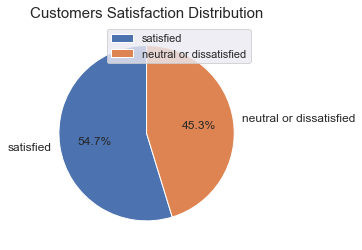

In [9]:
def fn_piePlot_binaryclass(df, binarycolname, p_labels, p_title):
    print ('Class 1: ', len(class1), ' - Percentage:',len(class1)*100/len(df))
    print ('Class 0: ', len(class0), ' - Percentage:',len(class0)*100/len(df))
    plt.figure(figsize = (5,5))
    plt.pie(df[binarycolname].value_counts(), labels = p_labels, autopct = '%1.1f%%', labeldistance=1.1, textprops = {'fontsize':12}, startangle=90)
    plt.title(p_title, fontsize=15)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

for binarycol in bin_cols:
    binarycolname = data_clean[binarycol].name #"satisfaction"
    p_labels = data_info[binarycolname]
    p_title = 'Customers Satisfaction Distribution'
    fn_piePlot_binaryclass(data_clean, binarycolname, p_labels, p_title)

# for binarycol in cat_cols:
#     binarycolname = class1[binarycol].name
#     p_labels = data_info[binarycolname]
#     p_title = str(binarycolname) + ' Distribution for Satified Customers'
#     fn_piePlot_binaryclass(class1, binarycolname, p_labels, p_title)    

At the first glance, regards to “Customers Satisfaction Distribution” pie chart,  
- Satisfied customers account 54.8% out of total customers that is a bit higher than dissatisfied customers which is 45.2%  

In [10]:
import plotly.express as px
fig = px.sunburst(data_clean, path=['Type of Travel','Class', 'Customer Type'],color_continuous_scale='RdBu')
fig.show()

In [11]:
import plotly.express as px
fig = px.sunburst(class1, path=['Type of Travel','Class', 'Customer Type'],color_continuous_scale='RdBu')
fig.show()

For customers who are satisfied (class 1)  
- In overall, 2/3 of them travel for business and 1/3 are personal travel.   
- For business travel customer, most of them go with business class. And almost of them are determined as loyal customer  
- For personal travel, they usually fly with eco class, a few of them experience eco plus and business class  
- Almost customers who is satisfied their flight are absolutely loyal customers.  
- Therefore, there is no big risk on satisfied customers. There are just a few of them that are disloyal.  
- We will investigate to see what these customers are satisfied.  


In [12]:
import plotly.express as px
fig = px.sunburst(class0, path=['Type of Travel','Class', 'Customer Type'],color_continuous_scale='RdBu')
fig.show()

For customers who are dis-satisfied (class 0):    
- In overall, the number of business travel is higher than personal travel.   
- For business travel customer, the customers are separated nearly equal for business and eco class. Around ½ customers of both two these class are disloyal.  
- For personal travel type, they usually fly with eco class, a few of them experience eco plus and business class. Almost customers travel with personal purpose are loyal customer. This mean that they are still loyal - customer even they are dis-satisfied with their flight  
- We will drill through data in next analysis to see who are dis-satisfied customers.   

In [13]:
def plot_pie(column) :
    
    trace1 = go.Pie(values  = class1[column].value_counts().values.tolist(),
                    labels  = class1[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "satisfaction",
                    marker  = dict(line = dict(width = 2, color = "rgb(243,243,243)")),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = class0[column].value_counts().values.tolist(),
                    labels  = class0[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,color = "rgb(243,243,243)")),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Dissatisfaction" 
                   )

    layout = go.Layout(dict(title = column + " distribution ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "satisfaction",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .2, y = .5),
                                           dict(text = "dissatisfaction",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

# for all categorical columns plot pie
for i in cat_cols :
    plot_pie(i) 

Customer satisfaction distribution by services


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224FE89CC08>,
      dtype=object)

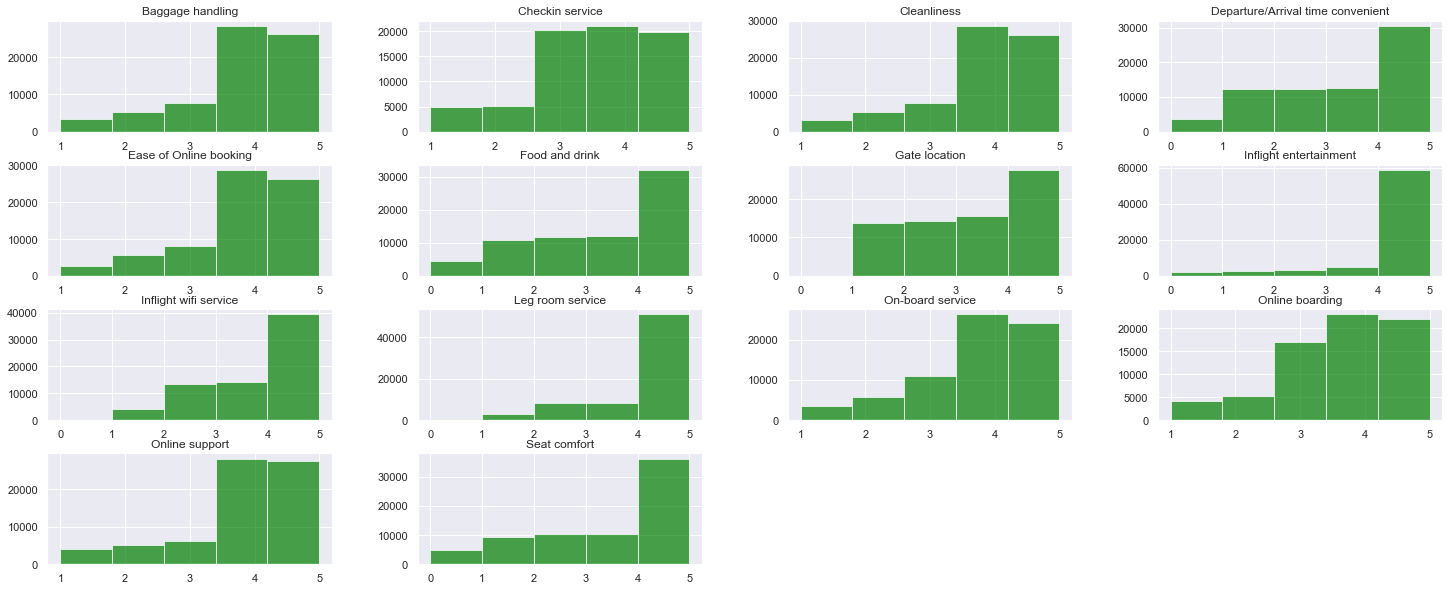

In [14]:
print('Customer satisfaction distribution by services')
class1.hist(column=score_cols,grid=True,figsize=(25,10),bins=5, color='green', alpha=0.7)

These histograms are to present the satisfaction customer distribution by all service level

- Most of satisfied customers rated level 4-5 for all services.  
- Very few number of satisfied customers rate level 1-3 for all services.
- Most of satisfied customers rate level 5 for "Inflight Entertainment", and "Leg room" services.  


Customer Dissatisfaction distribution by services


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224F7411348>,
      dtype=object)

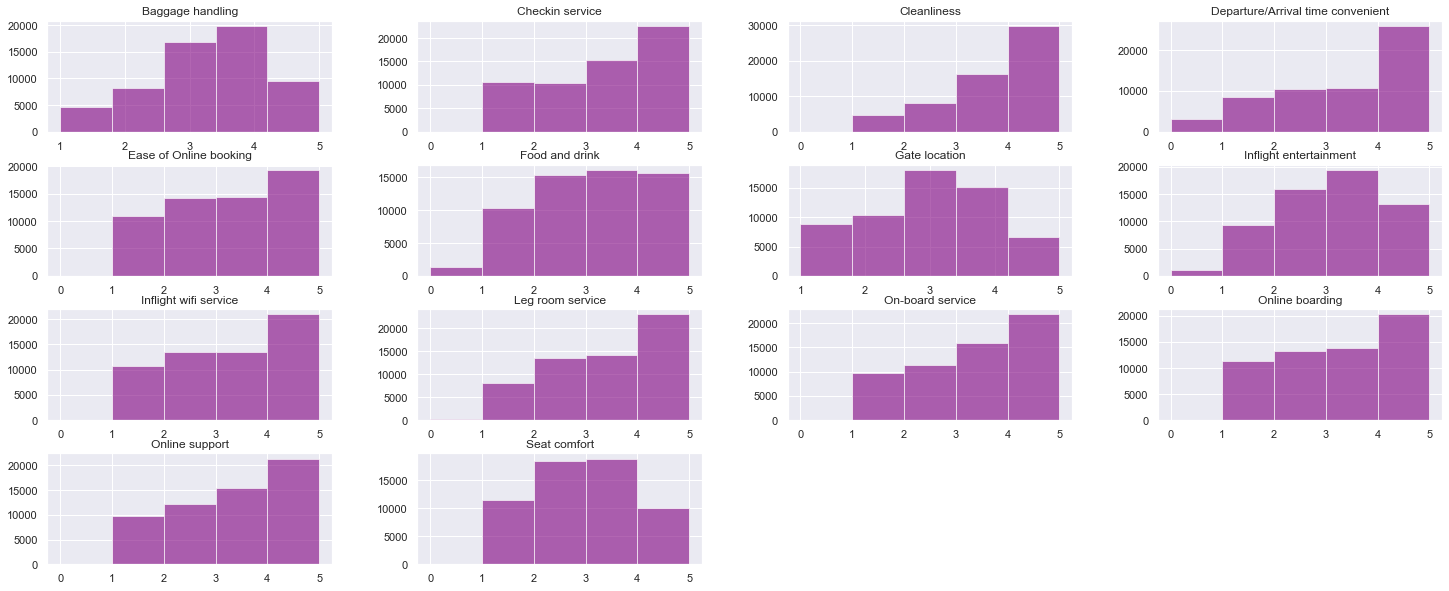

In [15]:
print('Customer Dissatisfaction distribution by services')
class0.hist(column=score_cols,grid=True,figsize=(25,10),bins=5, color='purple', alpha=0.6)

These histograms are to present the dissatisfaction customer distribution by all service level 
- Most of dissatisfied customers rated from 1 to 4 for "Departure/Arrival time convenient". This means that this service is not liked by customers who are dissatisfied the flight. This can be considered as a bad service.
- No much dissatisfied customers rate level 5 for "Baggage handling", "Gate Location", and "Seat Comfort" services


### <font color='purple'>Data Preprocessing</font> 

In [16]:
def fn_handle_category_data(df):
    print("7.Handling categorical data")
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes
    print("+++ Data.shape after handling missing category data:",df.shape)
    return df

In [17]:

# encode category - convert to numeric
data=fn_handle_category_data(data)

print('Data after pre-processing')
print('*** Data shape: ', data.shape)
data_info=sniff_modified(data)
nb_missing_cols = len(data_info[data_info['percent missing']>0])
if (nb_missing_cols ==0):
    print('There is no missing data in the dataset')
else:
    data_info[data_info['percent missing']>0]
    
data_info

7.Handling categorical data
+++ Data.shape after handling missing category data: (129880, 23)
Data after pre-processing
*** Data shape:  (129880, 23)
There is no missing data in the dataset


,data type,percent missing,nb of unique,unique values
satisfaction,int8,0.0,2,"[1.0, 0.0]"
Gender,int8,0.0,2,"[0.0, 1.0]"
Customer Type,int8,0.0,2,"[1.0, 0.0]"
Type of Travel,int8,0.0,2,"[1.0, 0.0]"
Class,int8,0.0,3,"[1.0, 0.0, 2.0]"
Online boarding,int64,0.0,6,"[2.0, 3.0, 5.0, 4.0, 1.0, 0.0]"
Cleanliness,int64,0.0,6,"[3.0, 4.0, 1.0, 2.0, 5.0, 0.0]"
Checkin service,int64,0.0,6,"[5.0, 2.0, 4.0, 3.0, 1.0, 0.0]"
Baggage handling,int64,0.0,5,"[3.0, 4.0, 1.0, 2.0, 5.0]"
Leg room service,int64,0.0,6,"[0.0, 4.0, 3.0, 2.0, 5.0, 1.0]"


In [18]:
data.to_csv('satisfaction_ready.csv', index = False) # Save the ready file which is used to apply for ML

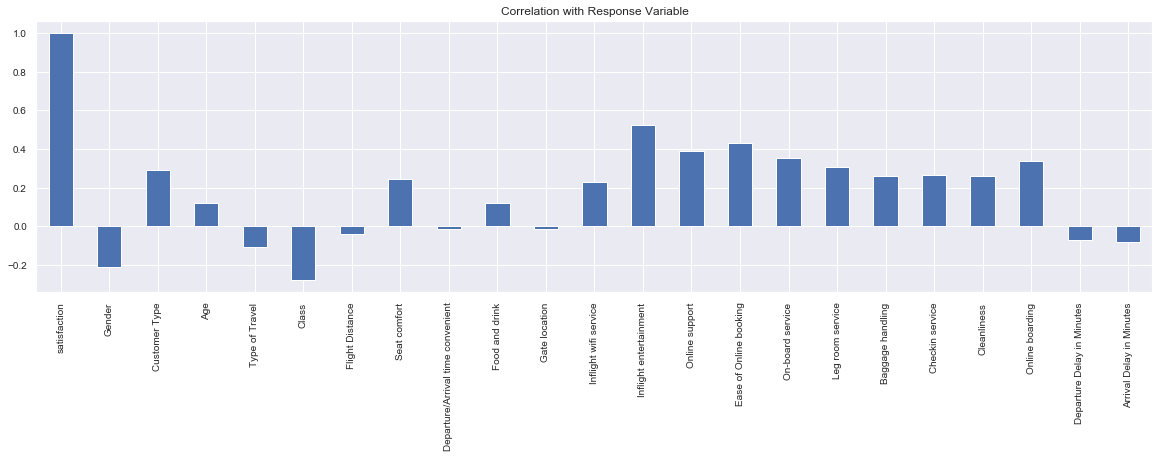

In [19]:
# Correlation Plot with the Response variable
data.corrwith(data.satisfaction).plot.bar(figsize = (20, 5), title = 'Correlation with Response Variable',fontsize = 10, rot = 90, grid = True)

- The correlation plot indicates the relationship between the target column that is "satisfaction" and all others columns. It is easy to realize that most of other field have correlation, especially the inflight entertainment which reach more than 0.5. Gender, Type of Travel, Class, Flight Distance, Departure Delay in Minutes and Arrival Delay in Minutes have reverse relationships.  
- Therefore, these columns are chosen to use as input variables because they can affect the output value.  

#### <font color='purple'>  PREPARING BEFORE BUILD MODEL </font>

In [20]:
# Import all the modules

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#### <font color='purple'>  common functions </font>

In [21]:
# DEFINE COMMON FUNCTIONS
def fn_scale_data(df):
    scaler = MinMaxScaler(feature_range=(0,1)) #desired range of transformed data between [0,1]
    df_scaled = scaler.fit_transform(df)    
    return df_scaled, scaler

def fn_split_data(p_X, p_Y, p_pct_train, p_pct_val):
    # p_pct_train is the percentage of train set. Example: p_pct_train=0.7
    # p_pct_val is the percentage of val set. Example: p_pct_val=0.1
    # test set is the remain
    
    nb_observation = p_X.shape[0]
    stop_point_train = int(np.floor(p_pct_train*nb_observation))
    stop_point_val = int(np.floor((p_pct_train+p_pct_val)*nb_observation))
    
    x_train=p_X[0:stop_point_train]
    y_train=p_Y[0:stop_point_train]
    
    x_val=p_X[stop_point_train:stop_point_val]
    y_val=p_Y[stop_point_train:stop_point_val]
    
    x_test=p_X[stop_point_val:]
    y_test=p_Y[stop_point_val:]
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def fn_fitmodel(modelobj, x_train, y_train, x_test, y_test):
    start_time = time.time()    
    modelobj.fit(x_train,y_train)
    y_test_pred = modelobj.predict(x_test)
    y_train_pred = modelobj.predict(x_train)
    enddt = datetime.now()
    training_duration =  time.time() - start_time
    #print('Total Training Time (second):', training_duration)    
    return y_test_pred, y_train_pred, training_duration, modelobj


def fn_accuracy_calc(df_acc, df_trainduration, p_model, y_test, y_test_pred, y_train, y_train_pred, AppendedFlag,training_duration):
    train_acc = accuracy_score(y_train, y_train_pred)
    train_f1_score = f1_score(y_train, y_train_pred)    
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1_score = f1_score(y_test, y_test_pred)    
    if (AppendedFlag>0):
            result={'model':[p_model],'test_acc':[test_acc],'test_f1_score':[test_f1_score],'train_acc':[train_acc],'train_f1_score':[train_f1_score]}
            duration={'model':[p_model], 'training duration':[training_duration]}
            df_acc = df_acc.append(pd.DataFrame(result),ignore_index=True)
            df_trainduration=df_trainduration.append(pd.DataFrame(duration),ignore_index=True)
    return train_acc, train_f1_score, test_acc, test_f1_score, df_acc, df_trainduration


def fn_confusionmatrix_binaryclf(p_model, y_test, y_test_pred, y_train, y_train_pred):
    title = 'Confusion matrix - ' + p_model
    cf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
    print(title)
    print(cf_matrix)
    
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap="YlGn",fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title(title, y=1.1)
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')

    print(classification_report(y_test,y_test_pred))
    return

def fn_plotaccdf(p_df, p_kind,p_xlabel,p_ylabel,p_title):
#    print("*******************************************************************************************************************")               
#    print("                               EVALUATION SCORES OF ALL MODELS                                                ")
#    print("*******************************************************************************************************************")   
    p_df.plot(kind = p_kind) # kind="bar"
    plt.xlabel(p_xlabel)
    plt.ylabel(p_ylabel)     
    plt.title(p_title)
    plt.legend(loc = 0)    
    plt.show()
    print(p_df[p_df.columns[1:]])

#Reset data frame to store accuracy information
def fn_resetdf():
    df = pd.DataFrame()
    return df

#### <font color='purple'>  initial </font>

In [22]:
## init
p_testsize=0.25
p_random_state = 0
df_acc=fn_resetdf()
df_trainduration = fn_resetdf()

data.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,0,1,65,1,1,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,1,1,1,47,1,0,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,1,0,1,15,1,1,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,1,0,1,60,1,1,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,1,0,1,70,1,1,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


#### <font color='purple'> input and target variables </font>

In [23]:
print('==========INPUT VARIABLES (X) and OUTPUT VARIABLES==========')
input_cols =  [i for i in data.columns if i not in Id_col + target_col]
X=pd.DataFrame(data[input_cols])
Y=data[target_col]
print('X.shape:',X.shape)
print('Y.shape:',Y.shape)

print('==========SCALE DATA==========')
X_scaled, scaler = fn_scale_data(X)

print('==========SPLITTING DATA==========')
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=p_testsize, random_state=p_random_state)
print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

==========INPUT VARIABLES (X) and OUTPUT VARIABLES==========
X.shape: (129880, 22)
Y.shape: (129880, 1)
==========SCALE DATA==========
==========SPLITTING DATA==========
x_train.shape: (97410, 22)
y_train.shape: (97410, 1)
x_test.shape: (32470, 22)
y_test.shape: (32470, 1)


#### <font color='purple'> BUILD MODELS </font>

=                    DECISION TREE CLASSIFIER                  =
Best Model Parameter:  {'max_depth': 10, 'min_samples_split': 10}
Best Model Estimator:  DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=0)
Best Score TEST: 0.9327687095780721
Best Score TRAIN: 0.9391438250692947
Confusion matrix - DT-CLF
[[13567  1053]
 [ 1130 16720]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.93     14620
           1       0.94      0.94      0.94     17850

    accuracy                           0.93     32470
   macro avg       0.93      0.93      0.93     32470
weighted avg       0.93      0.93      0.93     32470

=                RANDOM FOREST CLASSIFIER                      =
Best Model Parameter:  {'bootstrap': True, 'max_features': 'auto', 'min_samples_split': 20, 'n_estimators': 50}
Best Model Estimator:  RandomForestClassifier(min_samples_split=20, n_estimators=50, random_state=0)
Best Score TEST: 0.9547582383738836


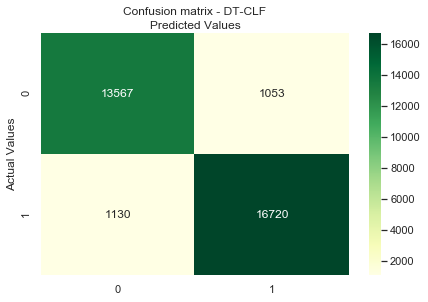

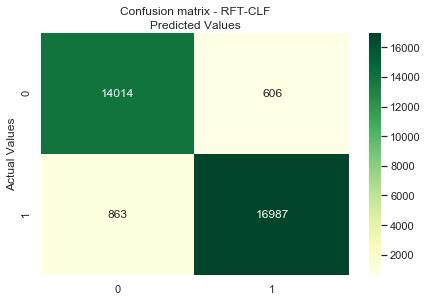

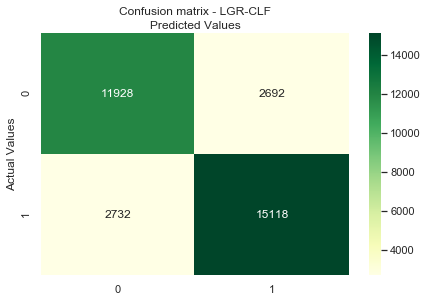

In [24]:

def fn_Build_DT_CLF(x_train,y_train,x_test,y_test,df_acc, df_trainduration):
    print('================================================================')
    print('=                    DECISION TREE CLASSIFIER                  =')
    print('================================================================')
    p_model='DT-CLF'

    param_grid= {"max_depth":range(10,15,20), "min_samples_split":range(10,15,20)}
    clf = DecisionTreeClassifier(random_state=p_random_state)
    
    cv = GridSearchCV(estimator=clf, param_grid = param_grid, cv=10)
  
    y_test_pred, y_train_pred, training_duration, model = fn_fitmodel(cv, x_train, y_train, x_test, y_test)
    
    print("Best Model Parameter: ",model.best_params_)
    print("Best Model Estimator: ", model.best_estimator_) #best estimator
    print("Best Score TEST:" , model.score(x_test, y_test))
    print("Best Score TRAIN:" , model.score(x_train, y_train))
    
    y_train_pred = model.best_estimator_.predict(x_train)
    y_test_pred = model.best_estimator_.predict(x_test)
    
    train_acc, train_f1_score, test_acc, test_f1_score, df_acc, df_trainduration = fn_accuracy_calc(df_acc, df_trainduration,p_model, y_test, y_test_pred, y_train, y_train_pred, 1, training_duration)

    fn_confusionmatrix_binaryclf(p_model, y_test, y_test_pred, y_train, y_train_pred)

    #nits_df = pd.DataFrame(model.cv_results_)
    return  df_acc, df_trainduration



def fn_Build_RFT_CLF(x_train,y_train,x_test,y_test,df_acc, df_trainduration):
    print('================================================================')
    print('=                RANDOM FOREST CLASSIFIER                      =')
    print('================================================================')
    p_model='RFT-CLF'

    param_grid = {
        'bootstrap': [True], # [True, False],
        'n_estimators': [50], # [20,50,100],
        'max_features': ['auto'], # ['auto', 'sqrt'],
        "min_samples_split": [20] #[10,15,20]
    }
        
    clf = RandomForestClassifier(random_state=p_random_state)
    
    cv = GridSearchCV(estimator=clf, param_grid = param_grid, cv=10)
  
    y_test_pred, y_train_pred, training_duration, model = fn_fitmodel(cv, x_train, y_train, x_test, y_test)
    
    print("Best Model Parameter: ",model.best_params_)
    print("Best Model Estimator: ", model.best_estimator_) #best estimator
    print("Best Score TEST:" , model.score(x_test, y_test))
    print("Best Score TRAIN:" , model.score(x_train, y_train))
    
    y_train_pred = model.best_estimator_.predict(x_train)
    y_test_pred = model.best_estimator_.predict(x_test)
    
    train_acc, train_f1_score, test_acc, test_f1_score, df_acc, df_trainduration = fn_accuracy_calc(df_acc, df_trainduration,p_model, y_test, y_test_pred, y_train, y_train_pred, 1, training_duration)

    fn_confusionmatrix_binaryclf(p_model, y_test, y_test_pred, y_train, y_train_pred)

    return  df_acc, df_trainduration


def fn_Build_LGR_CLF(x_train,y_train,x_test,y_test,df_acc, df_trainduration):
    print('================================================================')
    print('=                LOGISTICS REGRESSION                          =')
    print('================================================================')
    p_model='LGR-CLF'
    
    clf = LogisticRegression(random_state=p_random_state)
            
    # Creating a pca object
    pca = PCA()
    
    pipe = Pipeline(steps=[('std_slc', scaler),
                           ('pca', pca),
                           ('logistic_Reg', clf)])   
        
    
    # Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)    
    #n_components = list(range(1,X.shape[1]+1,1))
    # 22 is the best from the prior executions. It's set directly to reduce the number of parameter combinations from gridsearchCV
    n_components = [22]
    
    # Creating a list of options for the regularization penalty
    #penalty = ['l1', 'l2'] 
    # 12 is the best from the prior executions. It's set directly to reduce the number of parameter combinations from gridsearchCV
    penalty = ['l2']  

    # Creating a list of values of the regularization parameter
    C = np.logspace(-4, 4, 50) 
    
    parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)
    
    cv = GridSearchCV(pipe, parameters)
  
    y_test_pred, y_train_pred, training_duration, model = fn_fitmodel(cv, x_train, y_train, x_test, y_test)
    
    print("Best Model Parameter: ",model.best_params_)
    print("Best Model Estimator: ", model.best_estimator_) #best estimator
    print("Best Score TEST:" , model.score(x_test, y_test))
    print("Best Score TRAIN:" , model.score(x_train, y_train))
    
    y_train_pred = model.best_estimator_.predict(x_train)
    y_test_pred = model.best_estimator_.predict(x_test)
    
    train_acc, train_f1_score, test_acc, test_f1_score, df_acc, df_trainduration = fn_accuracy_calc(df_acc, df_trainduration,p_model, y_test, y_test_pred, y_train, y_train_pred, 1, training_duration)

    fn_confusionmatrix_binaryclf(p_model, y_test, y_test_pred, y_train, y_train_pred)

    return  df_acc, df_trainduration




df_acc, df_trainduration = fn_Build_DT_CLF(x_train, y_train, x_test, y_test, df_acc, df_trainduration)

df_acc, df_trainduration = fn_Build_RFT_CLF(x_train, y_train, x_test, y_test, df_acc, df_trainduration)

df_acc, df_trainduration = fn_Build_LGR_CLF(x_train, y_train, x_test, y_test, df_acc, df_trainduration)

#### <font color='purple'> Plot Accuracy and Training Duration </font>

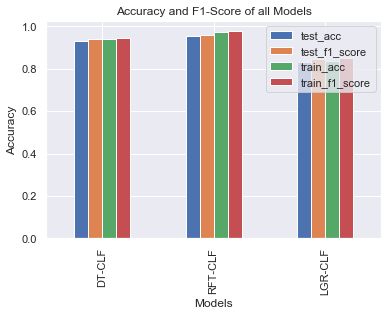

         test_acc  test_f1_score  train_acc  train_f1_score
model                                                      
DT-CLF   0.932769       0.938719   0.939144        0.944274
RFT-CLF  0.954758       0.958553   0.975321        0.977278
LGR-CLF  0.832953       0.847897   0.836721        0.850664


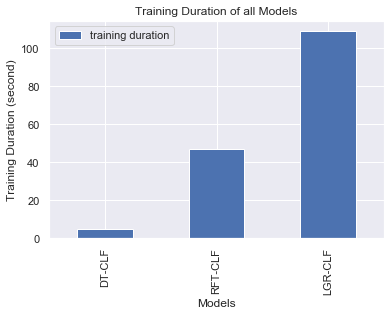

         training duration
model                     
DT-CLF            4.875170
RFT-CLF          46.841913
LGR-CLF         109.072747


In [25]:
#Plot all evaluation results from all models
df_acc.index=df_acc['model']
fn_plotaccdf(df_acc, p_kind='bar',p_xlabel='Models',p_ylabel='Accuracy',p_title='Accuracy and F1-Score of all Models')

#Plot all evaluation results from all models
df_trainduration.index=df_trainduration['model']
fn_plotaccdf(df_trainduration, p_kind='bar',p_xlabel='Models',p_ylabel='Training Duration (second)',p_title='Training Duration of all Models')